<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone: Online News Popularity


# 2. MACHINE LEARNING

### STEPS GUIDE

- I ran a linear regression using all features after features engineering to predict the number of shares an article would have. However, given the high variance of the target, I transformed the target value to a binary category then I applied the regression model in a classification analyis.

- Since I had applied PCA to reduce the dimensionality I divided the analysis in both: with all features and with the components from PCA. 


In this section, I did the following:

[1. Features: all initial columns](#lr1)  
- [Step 1: Linear Regression](#lr1)  
   - [1.1 LR model](#lr2)
   - [1.2 LR Lasso](#lr3)
   - [1.3 LR Ridge](#lr4) 
- [Step 2: Logistic Regression](#lr1)  
   - [1.1 Optimal Using RFECV](#lr2)
   - [1.2 Feature elimination using the Lasso penalty](#lr3)
   - [1.3 GR LR and RF](#lr4) 


[2. Features: PCA components](#lrpc1)  
- [Step 2: Linear Regression](#lrpc1)  
    - [2.1 LR model](#lrpc2)
    - [2.2 LR Lasso](#lrpc3)
    - [2.3 LR Ridge](#lrpc4)
- [Step 3: Logistic Regression](#lorpc1)  
    - [2.0 GridSearch LR](#lorpc2)
    - [2.1 KNN](#lorpc2)
    - [2.2 Ramdom Forest](#lorpc3)
    - [2.3 GS Ramdom Forest](#lorpc31)
    - [2.4 DecisionTreeClassifier](#lr4)
    - [2.5 Optim DecisionTreeClassifier](#lr5)
    - [2.6 BaggingClassifier with the base estimator](#lr6)        
    - [2.7 SVM (RBF)](#lr7)
    - [2.8 SVM (Linear)](#lr8)
    - [2.9 SVM (Poly)](#lr9)  
    
[2. Summary](#lr10)    
[3. First Insights](#lr11)    

In [1]:
import pandas as pd
import csv
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Loading files : with main variables and with PCA

In [2]:
df = pd.read_csv('./df.csv')
Xstd_to_PCX = pd.read_csv('./Xstd_to_PCX')
print df.shape
print Xstd_to_PCX.shape

(38818, 64)
(38818, 23)


## Defining Target and Features Set

 - #### TARGET: number of shares an article will be have

In [3]:
# The dependent variable is continuous
y = df.y

# I discretized the target value to binary cagegory
y_c = df.y_c

- #### FEATURES:  All variables 

In [4]:
cols =['shares_log','shares','url','y','y_c']

X_col = [col for col in df.columns if col not in cols]
X = df[X_col]
X.shape

(38818, 59)

- #### FEATURES: PCA


In [5]:
Xstd_to_PCX = pd.read_csv('./Xstd_to_PCX')

Xstd_to_PCX.shape

(38818, 23)

#### Feature Scaling 

Feature scaling is a method used to standardise the range of independent variables or features of dataset.
It is important to scale features to ensure that features with a comparatively high variance do not dominate a given model. Scaling the data for all models will make comparing models (MSE) simpler.

In [6]:
# Standarization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xstd = scaler.fit_transform(X)

In [7]:
# Created a new DataFrame as  Scaler transformsed DataFrame in an array and
# I will need a DataFrame to show coefficients later
Xstd_new = pd.DataFrame(Xstd, columns=X.columns)


I dont need to apply standard Scaler to PCA as it was previously done.

<a id='lr1'></a>

# 1. FEATURES:  All variables 

<a id='lr1'></a>
# Step1 Linear Regression

I applied Linear Regression to get a fast start. Linear regression is an "ordinary least squares" method for modeling the relationship between a scalar dependent variable and one or more explanatory variables (or independent variables) denoted X. 

In [8]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics


In [9]:
# Fitting a linear regression model to all the data.
# If the feature space has a linear realtionship with the target, the model should produce reasonable results.

lr = LinearRegression() # define model
model = lr.fit(Xstd_new, y) # fitting the model with all features
predictions = model.predict(Xstd_new) # predict using model
print 'MSE: \t', round (mean_squared_error(y, predictions),3) # mean squared error
print 'R2: \t', round (r2_score(y, predictions),3) # R2 score
print '-----------------------------------------------------------------------------------'



MSE: 	0.588
R2: 	0.127
-----------------------------------------------------------------------------------


> - If MSE value will show 0 and R2 value 1 then the model will be predicting with 100% accuracy.
> - R2 = 12 %, only 12% is the amount of variance explained above baseline in the target y by our predictor X variables.
 

- Implementing a train-test-split will reduce the bias in the model's performance. Considering that applying all the data we can not analyze how the model perform on unseen data, it could be over fiting.  



In [11]:
# Implementing a train-test-split will reduce the bias in the model's performance (using random_state for reproducibility)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd_new, y, random_state=200 , test_size=0.33)

# Create an Instance of the model
linreg = LinearRegression()

#Fit the model with the training data
model_lr = linreg.fit(Xtrain, ytrain)

#Predictions
yhat = linreg.predict(Xtest)

#Asses the model we just fitted with the test data
mse_test = mean_squared_error(yhat, ytest)
print 'Test MSE \t', round (mean_squared_error(ytest,yhat),3)
print 'Test R2: \t', round (r2_score(ytest,yhat),3) 
print '-----------------------------------------------------------------------------------'


Test MSE 	0.594
Test R2: 	0.119
-----------------------------------------------------------------------------------


<a id='lr2'></a>
### 1.1 Lasso

We have 58 features - I could use gridsearch to do some massive search
across lasso, ridge, elasticnet, but I'm going for a simpler route and 
just choosing to use lasso because I feel like with this row-to-col
dimensionality. 
Basically - I wanted a subset of the features selected - I used 
cross-validation to find the best regularization strength. We saw
how many features were selected as useful.

Lasso (Least Absolute Shrinkage and Selection Operator) penalized the absolute size of the regression coefficients. It was capable of reducing the variability and improving the accuracy of linear regression models. Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function,instead of squares. This leads to penalizing (or equivalently constraining the sum of the absolute values of the estimates) values which causes some of the parameter estimates to turn out exactly zero. Larger the penalty applied, further the estimates get shrunk towards absolute zero. This results to variable selection out of given n variables.



In [12]:
from sklearn.linear_model import LassoCV

In [13]:
lasso_cv = LassoCV(n_alphas=300, cv=10, verbose=0, random_state=200)
lasso_cv.fit(Xtrain, ytrain)

/Users/cristinagomez/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=200, selection='cyclic', tol=0.0001,
    verbose=0)

In [14]:
# I'm going to make a plot of the mean CV MSE, and some 
# bands for the standard deviation of MSE. I'll plot them
# along the alphas. 
# I will also plot a line where the best alpha was found.
mean_mse = np.array([np.mean(x) for x in lasso_cv.mse_path_])
std_mse = np.array([np.std(x) for x in lasso_cv.mse_path_])
alphas = lasso_cv.alphas_

best alpha =  0.000381266449989


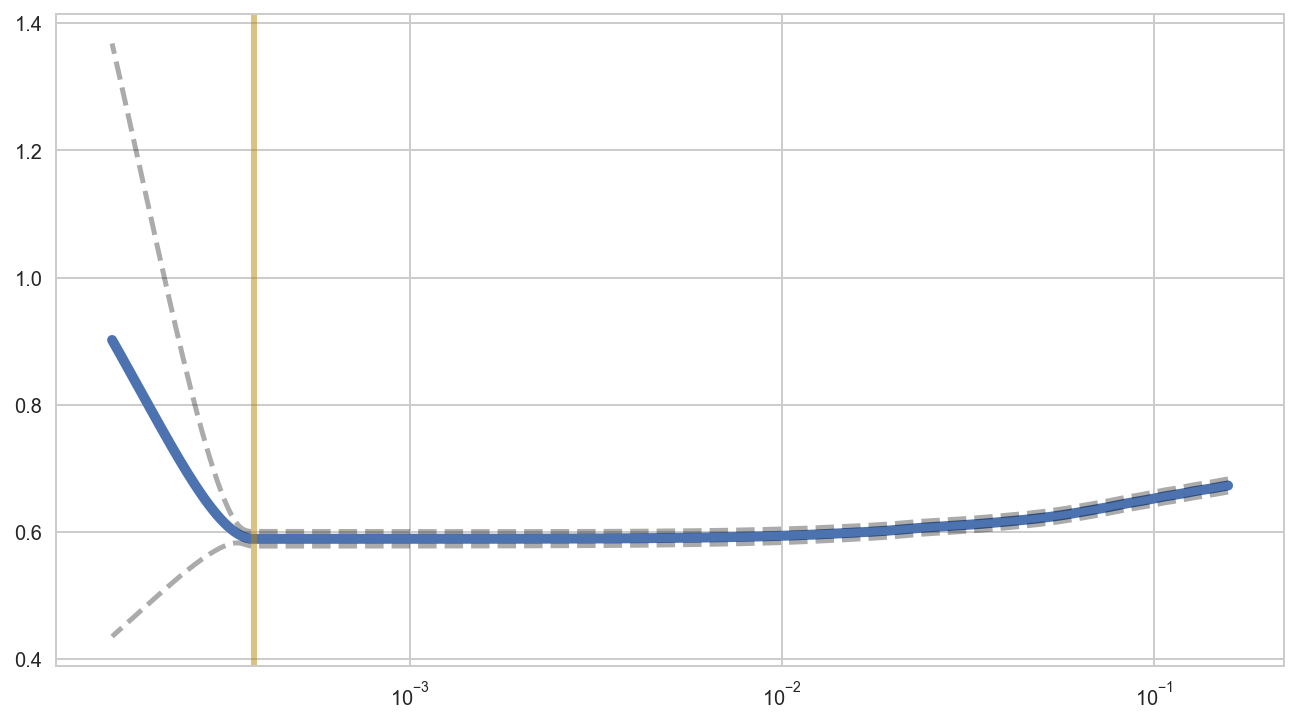

In [15]:
std_plus = mean_mse+std_mse/2.
std_minus = mean_mse-std_mse/2.

fig, ax = plt.subplots(figsize=(11,6))
ln_alphas = np.log(alphas)

ax.plot(alphas, mean_mse, lw=5)
ax.plot(alphas, std_plus, lw=2.5, ls='dashed', c='black', alpha=0.33)
ax.plot(alphas, std_minus, lw=2.5, ls='dashed', c='black', alpha=0.33)

min_mse = np.min(mean_mse)
best_alpha = np.where(mean_mse == min_mse)[0][-1]

ax.axvline(x=alphas[best_alpha], lw=3, c='darkgoldenrod', alpha=0.5)
plt.xscale('log')
print 'best alpha = ', lasso_cv.alpha_
plt.show()

In [16]:
from sklearn.linear_model import Lasso
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(Xtrain, ytrain)
yhat_lasso = best_lasso.predict(Xtest)
mse_lasso = mean_squared_error(ytest,yhat_lasso)


print "Best_lasso)MSE:\t", round (mse_lasso,3)
print 'Best Lasso R2: \t', round (r2_score(ytest,yhat_lasso),3) 
print '-----------------------------------------------------------------------------------'


Best_lasso)MSE:	0.594
Best Lasso R2: 	0.119
-----------------------------------------------------------------------------------


#### Feauture Importance

> - The model shows a high value of intercept. The intercept is the expected mean value of Y when all X=0. I removed it from the plot to can provide a best interpretation of the coefficients

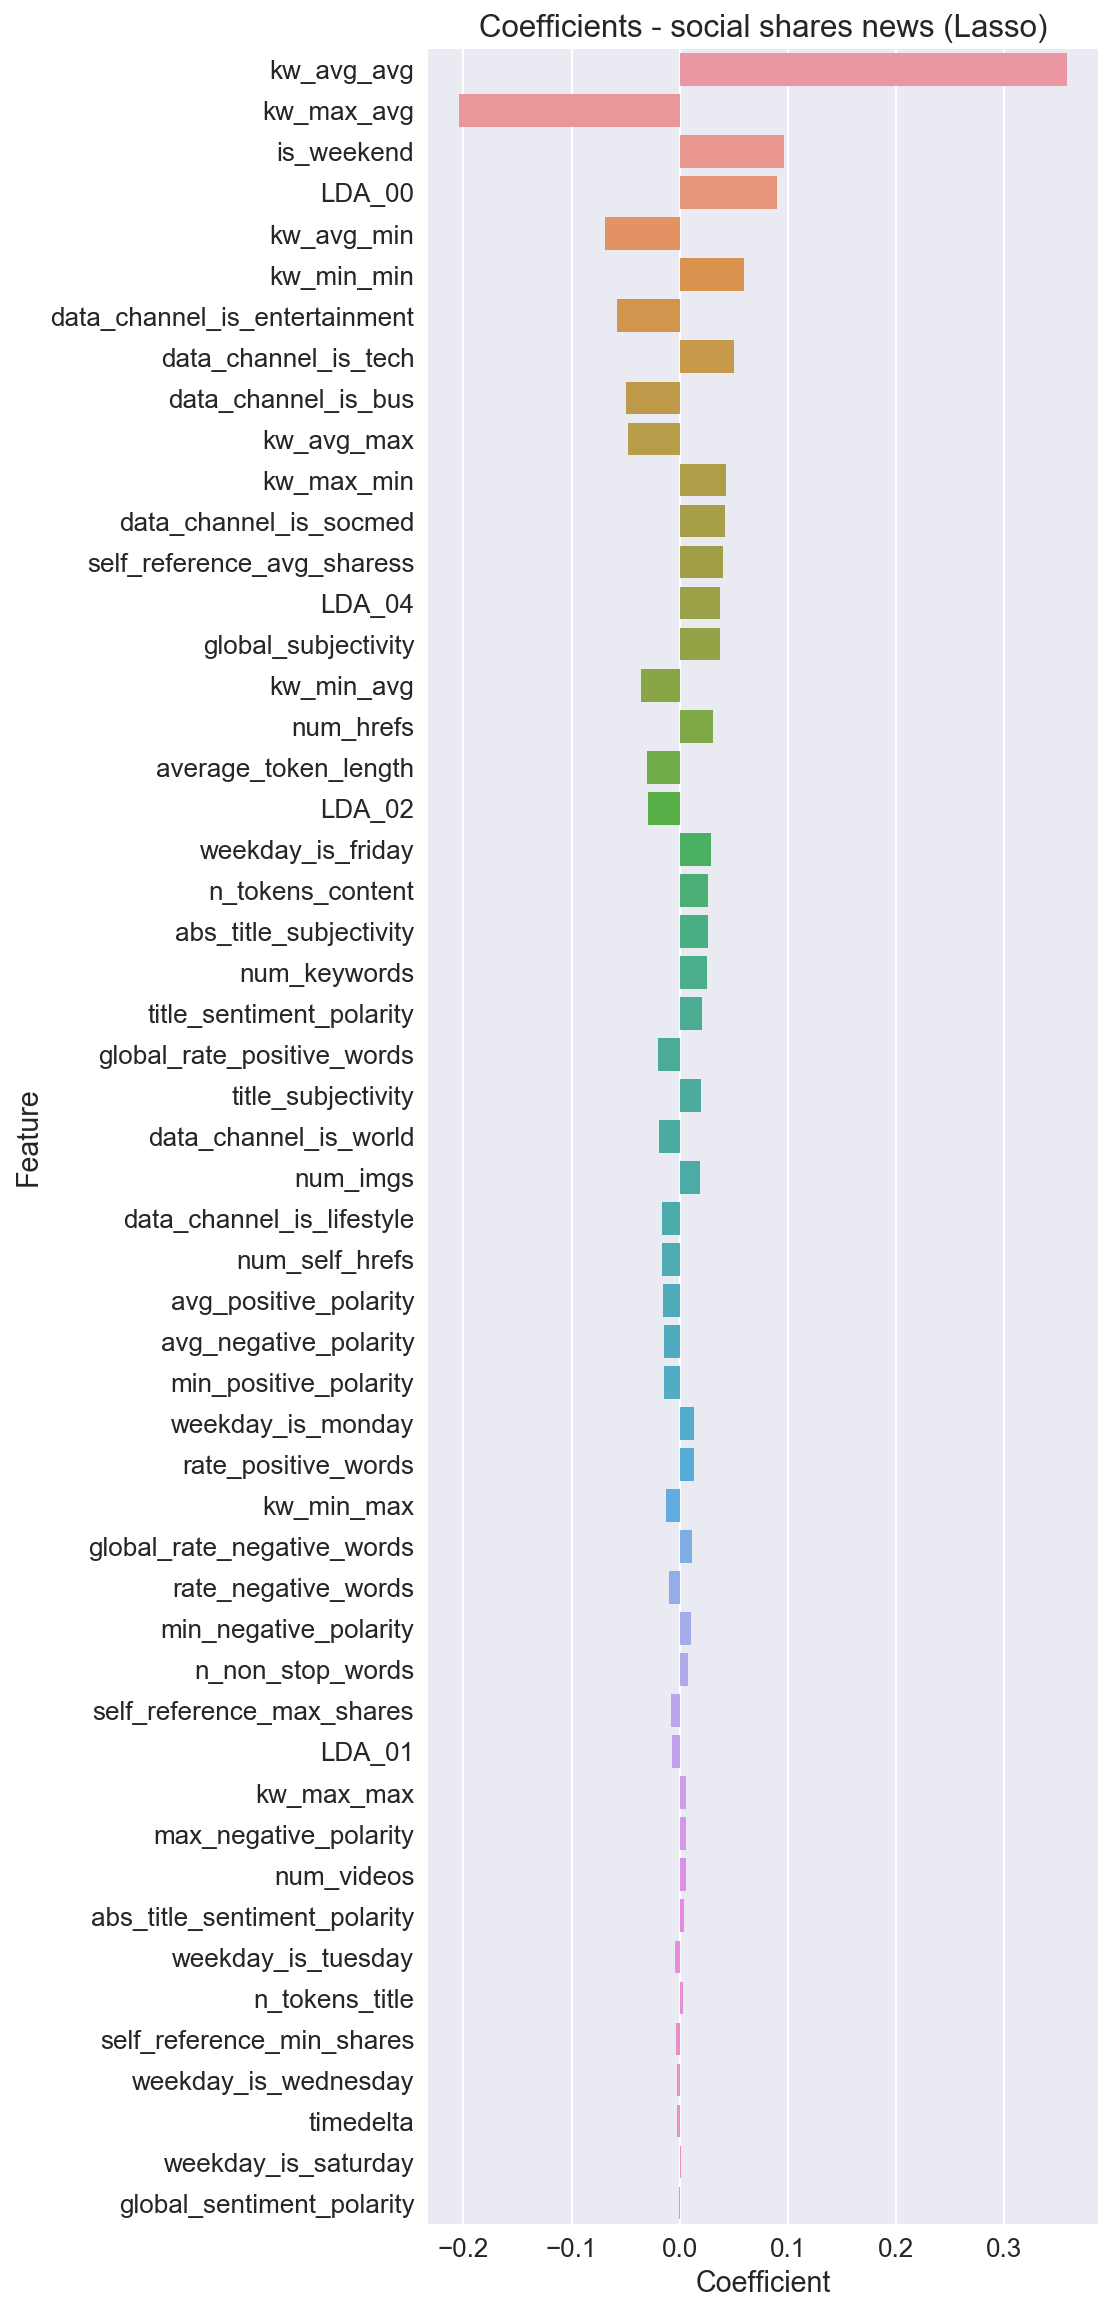

In [17]:
# Let's save the coefficients from the Logistic Regression (best lasso):
coef_lr1 = list(best_lasso.coef_)


# Creating a DF out of the coefficients, and sorting them in order of importance of their absolute value:
coefDF_lr1 = pd.DataFrame(coef_lr1,\
                                index = [str(i) for i in Xtrain.columns],\
                                columns=['Coefficients'])
coefDF_lr1['AbsoluteValue'] = coefDF_lr1['Coefficients'].map(lambda x: np.abs(x))
coefDF_lr1.sort_values(by='AbsoluteValue', ascending=False).head(5)

# Saving the new sorted dataframe, without the coefficients=0:
coeflr1_sortedDF = coefDF_lr1[coefDF_lr1['Coefficients']!=0].sort_values(by='AbsoluteValue', ascending=False)

# Plotting it:
plt.figure(figsize=(6,20))
sns.set(font_scale=1.3)
sns.barplot(coeflr1_sortedDF['Coefficients'],\
            list(coeflr1_sortedDF.index),\
            orient='h')
plt.title("Coefficients - social shares news (Lasso)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

There are 53 selected features! That's quite a few. The top variables make sense as far as what is important to estimate the number of shares:

> - TOP3 Coefficient

> **kw_ave_max**

> **kw_max_max (the lower is the maximun influence)**

> **is_weekend**

> - **The two highest predictors are related to content**. This seems that the editorial content of an article its more predictive than the rest of features


<a id='lr3'></a>
### 1.2 Ridge

- Searching over the ridge this time. Instead of going
for feature elimination I was looking to mitigate multicollinearity


In [18]:
from sklearn.linear_model import RidgeCV
sha_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)
sha_cv.fit(Xtrain, ytrain)
yhat_ridge = sha_cv.predict(Xtest)
mse_ridge = mean_squared_error(ytest,yhat_ridge)

print "(Ridge)MSE:\t", round (mse_ridge,3)
print '(Ridge)R2 :\t', round (r2_score(ytest,yhat_ridge),3) 
print '-----------------------------------------------------------------------------------'



(Ridge)MSE:	0.596
(Ridge)R2 :	0.116
-----------------------------------------------------------------------------------


#### Feauture Importance

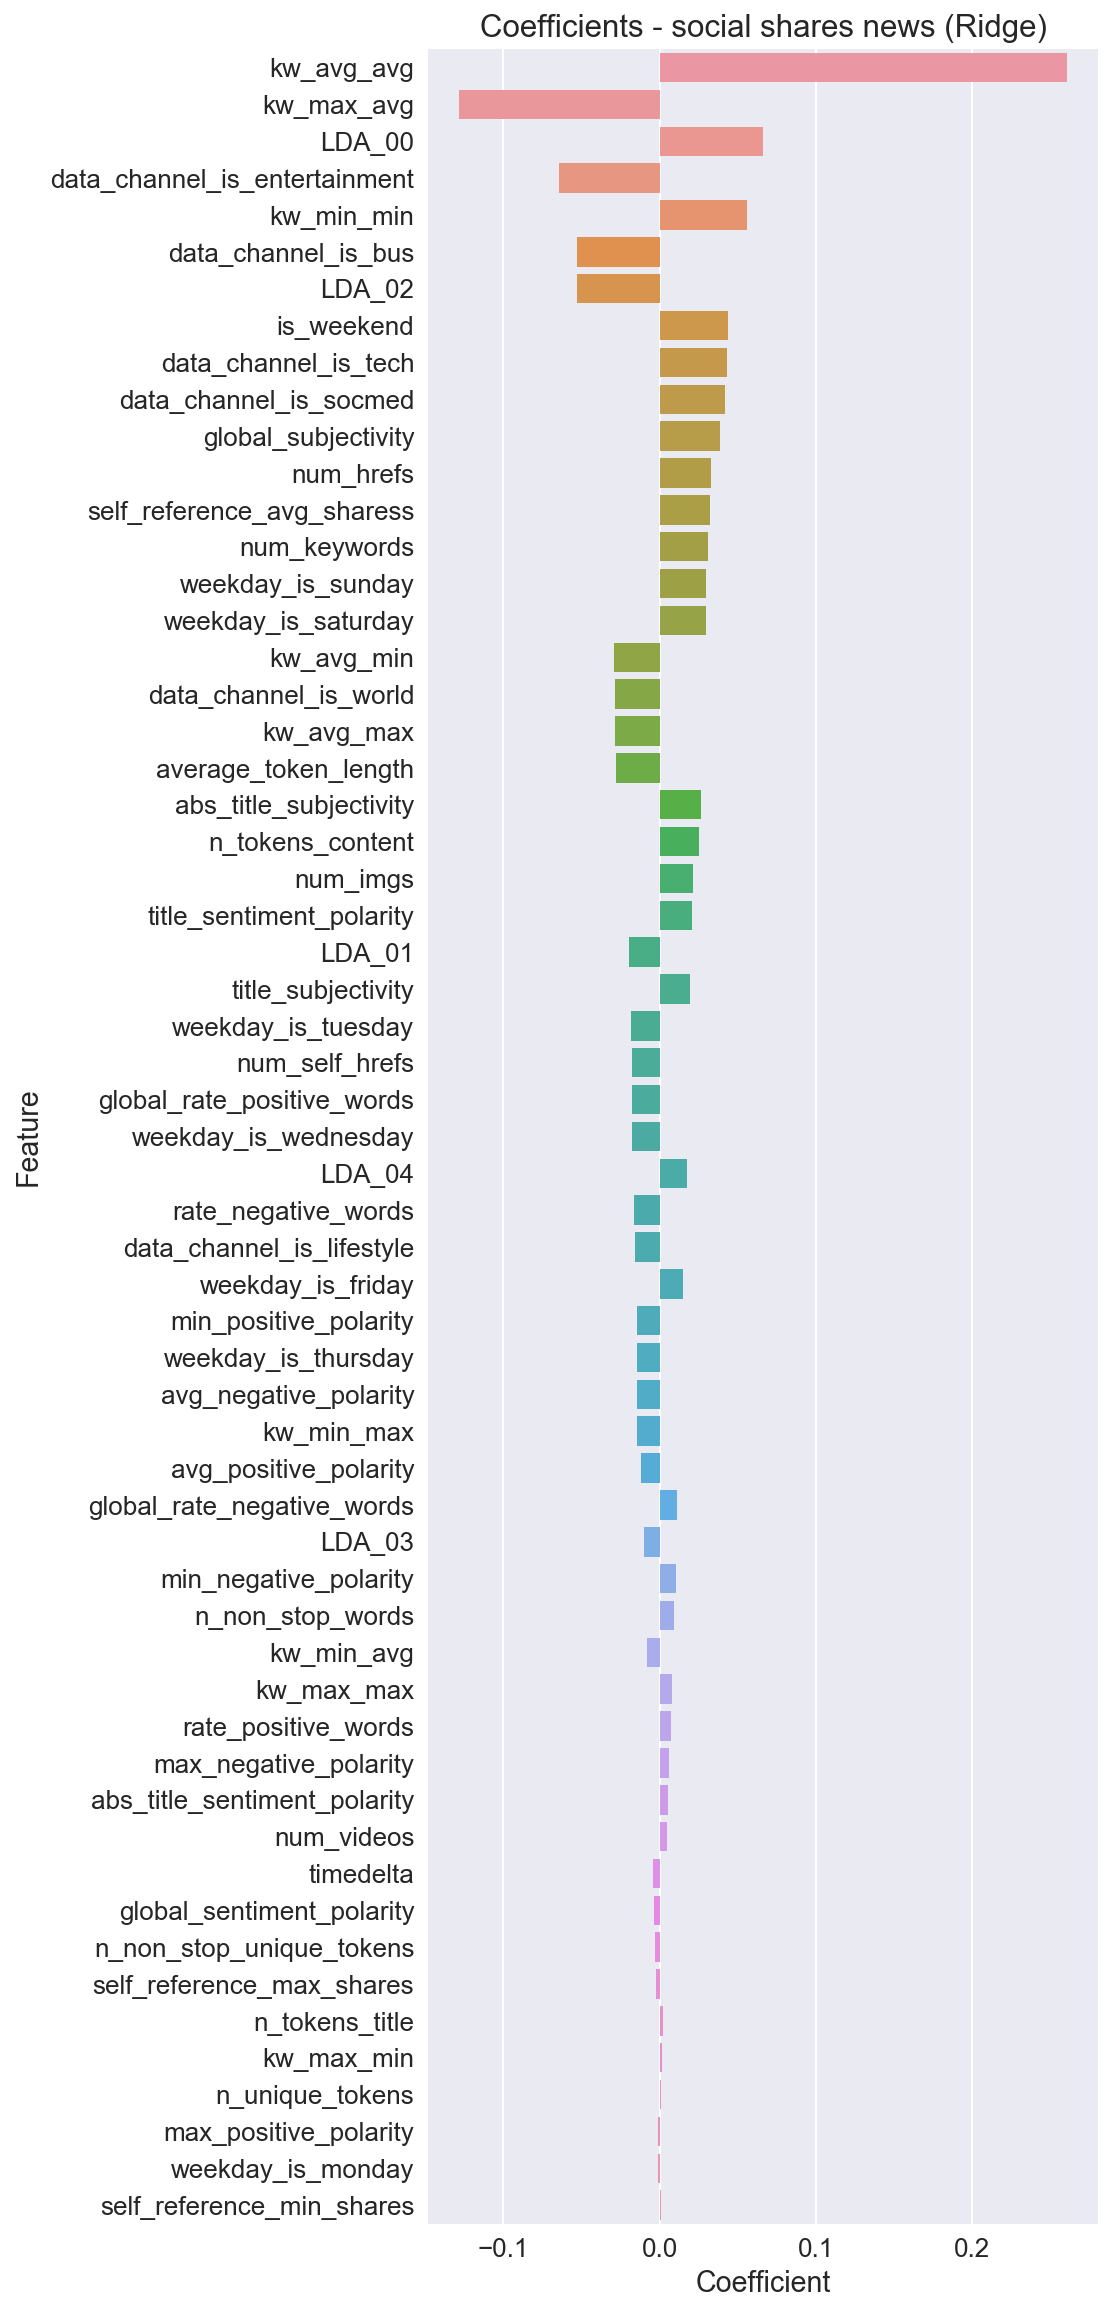

In [19]:
# Let's save the coefficients from the Logistic Regression (ridge):
coef_rid = list(sha_cv.coef_)


# Creating a DF out of the coefficients, and sorting them in order of importance of their absolute value:
coefDF_rid = pd.DataFrame(coef_rid,\
                                index = [str(i) for i in Xtrain.columns],\
                                columns=['Coefficients'])
coefDF_rid['AbsoluteValue'] = coefDF_rid['Coefficients'].map(lambda x: np.abs(x))
coefDF_rid.sort_values(by='AbsoluteValue', ascending=False).head(5)

# Saving the new sorted dataframe, without the coefficients=0:
coefrid_sortedDF = coefDF_rid[coefDF_rid['Coefficients']!=0].sort_values(by='AbsoluteValue', ascending=False)

# Plotting it:
plt.figure(figsize=(6,20))
sns.set(font_scale=1.3)
sns.barplot(coefrid_sortedDF['Coefficients'],\
            list(coefrid_sortedDF.index),\
            orient='h')
plt.title("Coefficients - social shares news (Ridge)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

> - The top features with highest score are: kw_ave_max,kw_max_max (the lower is the maximun influence) coinciding with Lasso coeficients.

> - **The three highest predictors are related to content**. Again the analysis tell us  that the current content of an article its more predictive than the rest of metadata variables.

> # Model Performance comparision - Mean Squared Error
> - ------------------------

The Mean Absolute Error (or MAE) is the sum of the absolute difference between predictions and actual values. It gives an idea of how wrong the predictions were. And, the Mean Squared Error provide a gross idea of the magnituede of error. Taking the square root of the mean squared error converts the unit back to the original units of the output variable.

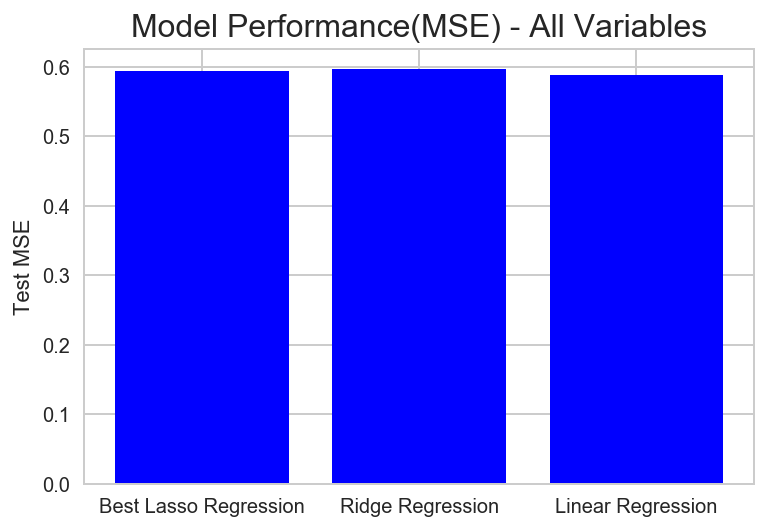

In [2]:
D = {'Linear Regression':0.588, 'Best Lasso Regression':0.594,'Ridge Regression':0.596}
color = sns.diverging_palette(h_neg=10, h_pos=250, s=90, l=30, as_cmap=True, center="light",)
plt.bar(range(len(D)), D.values(),align='center', color = "b")
plt.xticks(range(len(D)), D.keys())
plt.ylabel('Test MSE')
plt.title('Model Performance(MSE) - All Variables', fontsize = 16)

plt.show()


> - Initial variables do not suffer multicollinearity, independent variables are not highly correlated, as Ridge and Lasso Regression have not reduced the standard errors.

In multicollinearity, even though the fewest squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge and lasso regression reduces the standard errors.

> - The model has an R2 of 0.12, which means that the predictor variables explain 12% of the variance in the target variable not explained by the baseline model. Many of the features are relatively insignificant.



- ** Due to the high variance of the target, linear Regression does not seem the best model **

<a id='lr1'></a>
# Step2 Logistic Regression

### Calculate baseline accuracy

In [20]:
baseline_acc = np.mean(y_c)
print "Baseline accuracy:", round (baseline_acc,3)

Baseline accuracy: 0.524


# Logistic Regression using recursive feature elimination RFECV

Sklearn also offers recursive feature elimination as a class named `RFECV`. Use it in combination with a logistic regression model to see what features would be kept with this method.

When instantiating the `RFECV`:
- `step` indicates what percent of features (or number of features if an integer) to remove at each iteration.
- `cv` indicates the number of cross-validation folds to use for evaluating what features are important.



In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
selector = RFECV(lr, step=1, cv=5, verbose=False)
selector = selector.fit(X, y_c)

print selector.support_
print selector.ranking_

[False False False  True  True  True False False False False False False
  True  True  True  True False  True False False False False False False
 False False False False False False False False False False  True  True
  True  True  True  True  True False False False False False  True False
  True  True  True False  True False  True False  True  True False]
[24 17 25  1  1  1 16 15 18 20 12 11  1  1  1  1  5  1 22 30 28 37 32 34 26
 27 23 29 35 31  9  7  6  8  1  1  1  1  1  1  1  4  3 33 10 19  1 14  1  1
  1 13  1 21  1 36  1  1  2]


In [24]:
from sklearn.metrics import accuracy_score

# Implementing a train-test-split will reduce the bias in the model's performance (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(Xstd_new, y_c, random_state=200 , test_size=0.33)
selector.fit(X_train, y_train)
pred_selector = selector.predict(X_test)

print "Baseline accuracy:\t\t\t\t\t", round (baseline_acc,3)
print "Logistic Regression (RFECV) test accuracy:\t\t\t", round ((accuracy_score(y_test,pred_selector)),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:					0.524
Logistic Regression (RFECV) test accuracy:			0.648
------------------------------------------------------------------------------------------


In [25]:
selector.n_features_

46

# Feature elimination using the lasso penalty

In [28]:
from sklearn.linear_model import LogisticRegressionCV

## Applying X Standardize (required for regularization!)
## Create a logistic regression cross-validator object :
##    - Set `penalty='l1'` (Lasso).
##    - Set `Cs=5` (search 5 different regularization strengths).
##    - Set `solver='liblinear'` (required for the Lasso penalty).
##    - Set `cv=5` for 5 cross-validation folds.
## Fit on the target and standardized predictors.
## Sort the logistic regression coefficients by absolute value. 

lrcv = LogisticRegressionCV(penalty='l1', Cs=5, cv=5, solver='liblinear')
lrcv.fit(Xstd_new, y_c)

pred_selector_lasso = lrcv.predict(X_test)

print "Baseline accuracy:\t\t\t\t\t", round (baseline_acc,3)
print "Logistic Regression (RFECV) test accuracy:\t\t\t", round (accuracy_score(y_test,pred_selector),3)
print "LR Grisearch (optimal parameters) test accuracy:\t\t\t", round (accuracy_score(y_test,pred_selector_lasso),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:					0.524
Logistic Regression (RFECV) test accuracy:			0.648
LR Grisearch (optimal parameters) test accuracy:			0.649
------------------------------------------------------------------------------------------


In [30]:
## the best coefficients according to a model using gridsearch best lasso
coeffs = pd.DataFrame(lrcv.coef_, columns=X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)


> - 21 variables were eliminated. Not totally consistent with RFECV 

### Feature importance

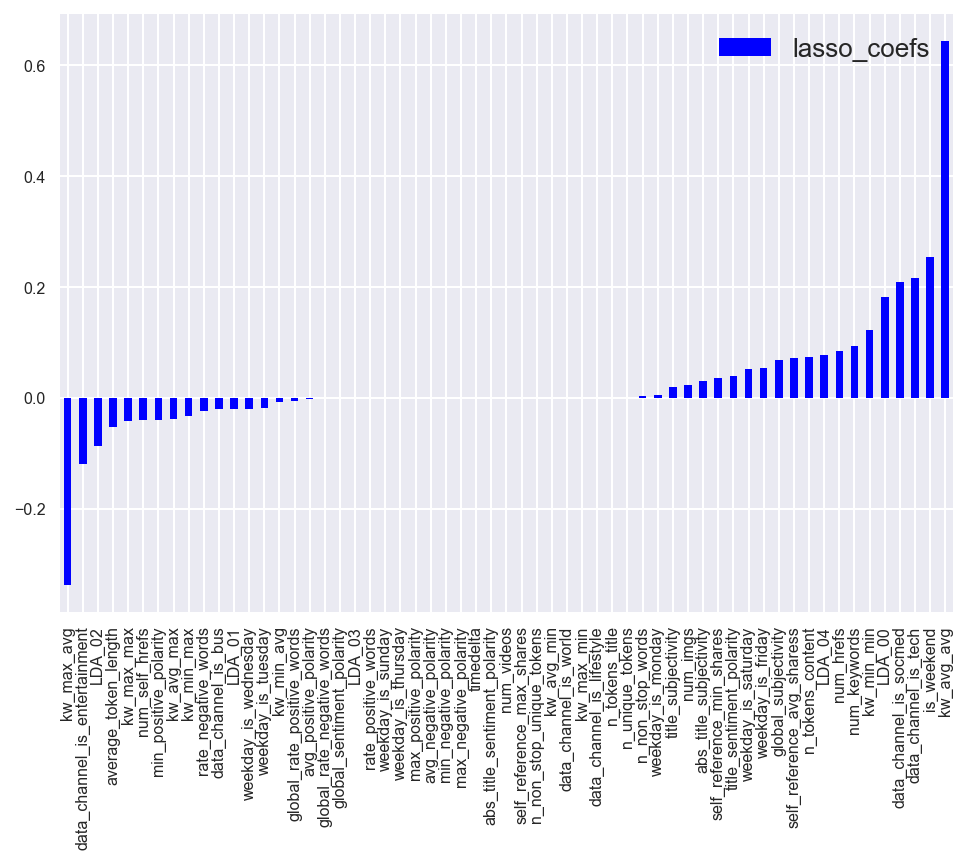

In [31]:
# Display the logistic regression coefficients with a barchart.
coeffs_t.sort_values('lasso_coefs').plot(kind='bar',color ="b",align='center',fontsize=8)
plt.show()




> - The two highest predictors correspond to the top3 significance features in linear regression: **kw_ave_max and kw_max_max (the lower is the maximun influence)**.

> - Another important feature is ** the Data Channel is tech** . This suggests that Mashable is providing useful content regarding technology.

> - It seems that the variables relative to the editorial content of online news is more predictive that the rest of features.

# Logistic Regression and Random Forest Classifier - Optimal Parameters

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def test_model(X, y,names, models, parameters, q = False):
    dict_of_models = {}
    
    for name, model, param in zip(names, models, parameters):
        if q: param = {}
        gs = GridSearchCV(model, param_grid=param, cv=3)
        gs.fit(X, y)
        score = accuracy_score(y, cross_val_predict(gs.best_estimator_, X, y))
        dict_of_models[name] = gs
        print ((name+ ' acc score:').ljust(14), score)
    return dict_of_models

model_names =['LogisticRegression','RandomForest']
models = [LogisticRegression(), RandomForestClassifier()]

lr_params = {'penalty': ['l1','l2'], 'C': np.logspace(-3, 3, 10)}
rf_params = {'max_features': [0.5], 'n_estimators':[600]}

params = [lr_params, rf_params]

result_model = test_model(X_test, y_test, model_names,models,params, q=True)

('LogisticRegression acc score:', 0.64894613583138172)
('RandomForest acc score:', 0.61436377829820454)


In [ ]:
print "Baseline accuracy:\t\t\t\t\t", round (baseline_acc,3)
print "Logistic Regression (optimal parameters) test accuracy:\t", round (result_model['LogisticRegression'].best_estimator_.fit(X_train,y_train).score(X_test,y_test),3)
print "RF (optimal parameters) test accuracy:\t\t\t", round (result_model['RandomForest'].best_estimator_.fit(X_train,y_train).score(X_test,y_test),3)
print '------------------------------------------------------------------------------------------'


> # Model Performance Logistic - Accuracy
> - ------------------------

In this case, I am using Accuracy to compare models. 

Baseline Accuracy =  0.524 

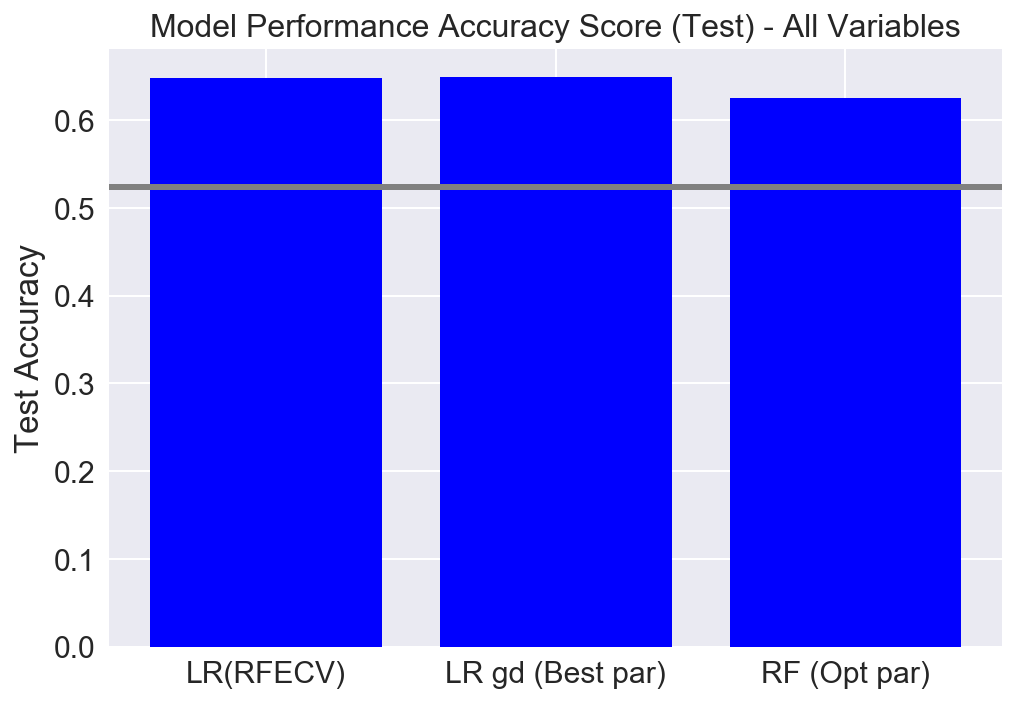

In [100]:
D = {'LR(RFECV)':0.648, 'LR gd (Best par)':0.649,'RF (Opt par)':0.625}

color = sns.diverging_palette(h_neg=10, h_pos=250, s=90, l=30, as_cmap=True, center="light",)
plt.bar(range(len(D)), D.values(),align='center', color = "b")
plt.xticks(range(len(D)), D.keys())
plt.axhline(0.524, label = 'Baseline Performance',lw=3, c='grey', alpha=1.0)
plt.ylabel('Test Accuracy')
plt.title('Model Performance Accuracy Score (Test) - All Variables', fontsize = 16)
print 'Baseline Accuracy =  0.524 ', 

plt.show()

In [140]:
# LR (RFECV) and LR(Best Lasso), There is basically no difference in performance for this dataset.

Using feature selection techniques, like RFECV,  do not seem to improve information compared to using all the features.

- **In order to simplify the dataset and improve performance, I used the top 23 principal componets**

<a id='lrpc1'></a>
# Features: PCA Components

<a id='lrpc1'></a> 
# Step 1 Linear Regression 

I explored if PCA components could improve the linear regression model.

In [40]:
Xtrain, Xtest, ytrain, ytest = train_test_split(Xstd_to_PCX, y,random_state = 200) 
print len(Xstd_to_PCX), len(y)

38818 38818


In [41]:

# Create an Instance of the model
linreg = LinearRegression()
#Linear regression cross-validated on original variables
original_scores = cross_val_score(linreg, Xtrain, ytrain, cv=10,)
#Fit the model with the training data
model = linreg.fit(Xtrain, ytrain)
#Predictions
yhat = linreg.predict(Xtest)
#Asses the model we just fitted with the test data
mse_test = mean_squared_error(yhat, ytest)

print 'Linear regression (default parameters) test r2 PCA:\t', round (r2_score(ytest,yhat),3)
print "Linear regression (default parameters) test mse PCA:\t", round (mse_test,3)
print '-------------------------------------------------------------------------------------------------------------'


Linear regression (default parameters) test r2 PCA:	0.082
Linear regression (default parameters) test mse PCA:	0.607
-------------------------------------------------------------------------------------------------------------


<a id='lrpc2'></a>
### 2.1 Lasso

In [42]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import LassoCV, Lasso
lasso_cv = LassoCV(n_alphas=300, cv=10)
lasso_cv.fit(Xtrain, ytrain)
best_lasso = Lasso(alpha=lasso_cv.alpha_)
best_lasso.fit(Xtrain, ytrain)
best_lasso.score(Xtest, ytest)
yhat_lasso = best_lasso.predict(Xtest)
mse_lasso = mean_squared_error(yhat_lasso, ytest)
r2_lasso = metrics.r2_score(ytest, yhat_lasso)

print "Linear regression (best_lasso) test mse:\t PCA", round (mse_lasso,3)
print '-------------------------------------------------------------------------------------------------------------'


Linear regression (best_lasso) test mse:	 PCA 0.607
-------------------------------------------------------------------------------------------------------------


<a id='lrpc3'></a>
### 2.2 Ridge

In [43]:
from sklearn.linear_model import RidgeCV
sha_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)
sha_cv.fit(Xtrain, ytrain)
yhat_ridge = sha_cv.predict(Xtest)
mse_ridge = mean_squared_error(yhat_ridge, ytest)

print sha_cv.alpha_
print sha_cv.score(Xtest, ytest)
print "Linear regression (ridge) test mse:\t", round (mse_ridge,3)
print '-------------------------------------------------------------------------------------------------------------'


5359.16329085
0.0827182830618
Linear regression (ridge) test mse:	0.607
-------------------------------------------------------------------------------------------------------------


> # Model Performance comparision - MSE
> - ------------------------

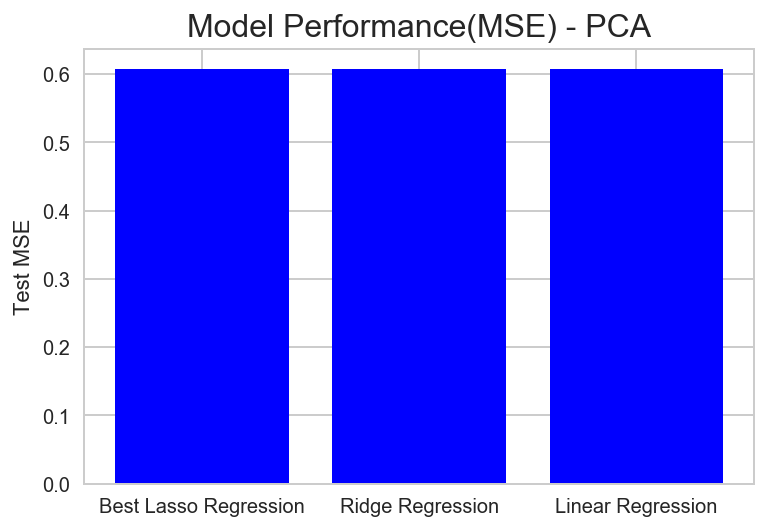

In [3]:
D = {'Linear Regression':0.607, 'Best Lasso Regression':0.607,'Ridge Regression':0.607}
color = sns.diverging_palette(h_neg=10, h_pos=250, s=90, l=30, as_cmap=True, center="light",)
plt.bar(range(len(D)), D.values(),align='center', color = "b")
plt.xticks(range(len(D)), D.keys())
plt.ylabel('Test MSE')
plt.title('Model Performance(MSE) - PCA', fontsize = 16)
plt.show()


> - The value of the model explained has a R2 of 0.08, which means that the predictor variables explain 8% of the variance in the target variable - not explained by the baseline model. Also,  the high variance of the target, linear Regression is not the best model to predict online news popularity.

<a id='lorpc1'></a>
# 2. Features: PCA Components

<a id='lorpc1'></a>
# Step 2 Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model, metrics, model_selection
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

# Test Models by introducing a *Test* or *Validaton* set
X_train, X_test, y_train, y_test = train_test_split(Xstd_to_PCX, y_c, test_size=0.33, random_state=42)


/Users/cristinagomez/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


> - As I mentioned before an alternative approach to regression is **to binarize the data into two categories**. To start I set the threshold value at the median, which is 1,400 shares and 7.24 (log shares).

### Baseline Accuracy

In [45]:
# Calculate baseline accuracy
baseline_acc = np.mean(y_c)
print "Baseline accuracy:", round (baseline_acc,3)

Baseline accuracy: 0.524


> - **Baseline Accuracy corresponds to Class 1 "the most popular news"**

### Cross-validation on train set:

 Examination of the Logistic Model 

In [48]:
# Create an Instance of the model
lr1 = LogisticRegression()

#Fit a logistic regression model with five-fold cross validation
cvscores_lr1= cross_val_score(lr1,Xstd_to_PCX,y_c,cv=5)
print "Baseline accuracy:\t\t\t\t\tt\t", round (baseline_acc,3)
print "Logistic regression (default parameters) cv5 accuracy PCA:\t", round (np.mean(cvscores_lr1),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:					t	0.524
Logistic regression (default parameters) cv5 accuracy PCA:	0.624
------------------------------------------------------------------------------------------


### Fitting on train set and Scoring on test set:

In [50]:
#Intensiate and fit the model on train set
lr1.fit(X_train, y_train)
#Predictions
yhat_lr1= lr1.predict(X_test)
# Evaluate test data
accuracy_score(y_test, yhat_lr1)

print "Baseline accuracy:\t\t\t\t\t\t", round (baseline_acc,3)
print "Logistic regression (default parameters) cv5 accuracy PCA:\t", round (np.mean(cvscores_lr1),3)
print "Logistic regression (default parameters) test accuracy PCA:\t", round (accuracy_score(y_test, yhat_lr1),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:						0.524
Logistic regression (default parameters) cv5 accuracy PCA:	0.624
Logistic regression (default parameters) test accuracy PCA:	0.631
------------------------------------------------------------------------------------------


In [51]:
# Examine the coefficients to see our correlations
print 'Logreg intercept:', model.fit_intercept
print 'Logreg coef(s):', model.coef_
print '------------------------------------------------------------------------------------------'


Logreg intercept: True
Logreg coef(s): [-0.03762654  0.0160289   0.06727375  0.0015305   0.0285588   0.02217266
 -0.03815905 -0.01988189  0.03768291 -0.06563091 -0.02774334 -0.07009602
 -0.04565603 -0.04059956 -0.0160101  -0.00012047 -0.00124147  0.00537577
  0.02039825 -0.0157672   0.00794332  0.03178699  0.03159299]
------------------------------------------------------------------------------------------


> - Many negative coefficients

### Parameter optimization: 

In [52]:
lreg_params = {'penalty': ['l1','l2'], 'C': np.logspace(-1,0,10)}
lr2 = GridSearchCV(lr1, param_grid=lreg_params, cv=5)
lr2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([ 0.1    ,  0.12915,  0.16681,  0.21544,  0.27826,  0.35938,
        0.46416,  0.59948,  0.77426,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
lr2.best_params_

{'C': 0.35938136638046275, 'penalty': 'l2'}

In [54]:
lr3 = lr2.best_estimator_.fit(X_train, y_train)

### Best logistic model

In [56]:
yhat_lr3 = lr3.predict(X_test)
print "Baseline accuracy:\t\t\t\t\t\t", round (baseline_acc,3)
print "Logistic regression (default parameters) test accuracy PCA:\t", round (accuracy_score(y_test, yhat_lr1),4)
print "Logistic regression (optimal parameters) test accuracy PCA:\t", round (accuracy_score(y_test, yhat_lr3),4)

Baseline accuracy:						0.524
Logistic regression (default parameters) test accuracy PCA:	0.6308
Logistic regression (optimal parameters) test accuracy PCA:	0.6308


In [128]:
# Predict the class probabilities for the *Test* set
predicted_prob = lr1.predict_proba(X_test)

Default and optimal parameter are equal which means regularization is weaker.

#### Classification report

In [58]:
print classification_report(y_test,yhat_lr3)

             precision    recall  f1-score   support

          0       0.62      0.57      0.59      6053
          1       0.64      0.69      0.66      6757

avg / total       0.63      0.63      0.63     12810



> - **f1_ score** gives us the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to the other class. This model shows a 0.66% high value of accuracy for class 1.

> - **Precision** - Model precision score of 0.63(total). Value 1 indicates that the classifier never mistakenly classified the current class as another class.  

> - **Recall** 0.63 The ability of the classifier to correctly identify the current class as no very high but not bad.

> - The number of observation is class 1 "popular new" is 6757 Vs. 6053 in class 0 "not popular news".

#### Confusion Matrix

The confusion matrix is a handy presentation of the accuracy of a model with two o more classes.

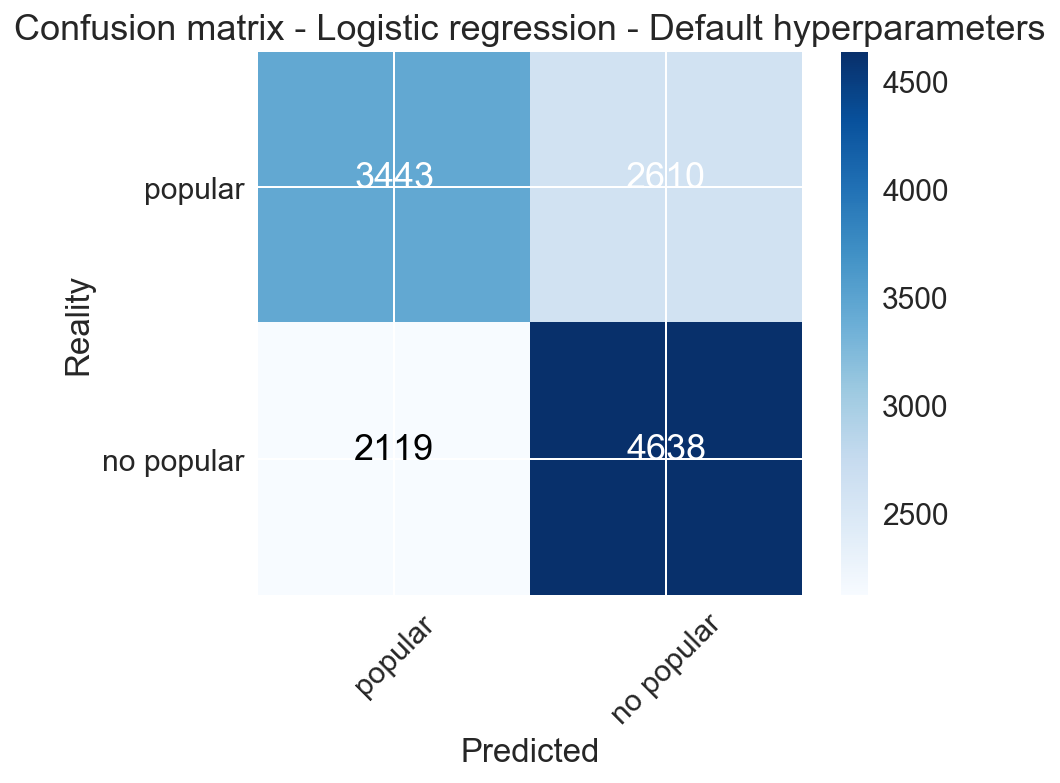

In [59]:
import itertools

# Function to plot the confusion matrices in a nicer and more interpretable way:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, xlab='Predicted label',\
                         ylab='True label'):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()

# Computing the confusion matrix
confmat_lr1 = confusion_matrix(y_test,yhat_lr1)

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmat_lr1, ['popular','no popular'],\
                      'Confusion matrix - Logistic regression - Default hyperparameters',\
                      xlab='Predicted', ylab='Reality')
plt.show()

> The ** confusion matrix ** is a table representing the performance of the model to classify labels correctly.


> - 3443 class 1 (popular new) observations class are correctly classified as class 1 by the model.

> - 4638 class 0  observations class are correctly classified as class 0 (no popular new) by the model.

> - 2129 class 0 (no popular new) observations are incorrectly classified as  popular new by the model.

> - 2610 class 1  observations are incorrectly classified as no popular by the model.

Most class 0 no popular news are correctly predicted. Lots of popular news are predicted as no popular (2610)

#### ROC Curve

In [129]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:,1])

roc_auc = auc(fpr, tpr)

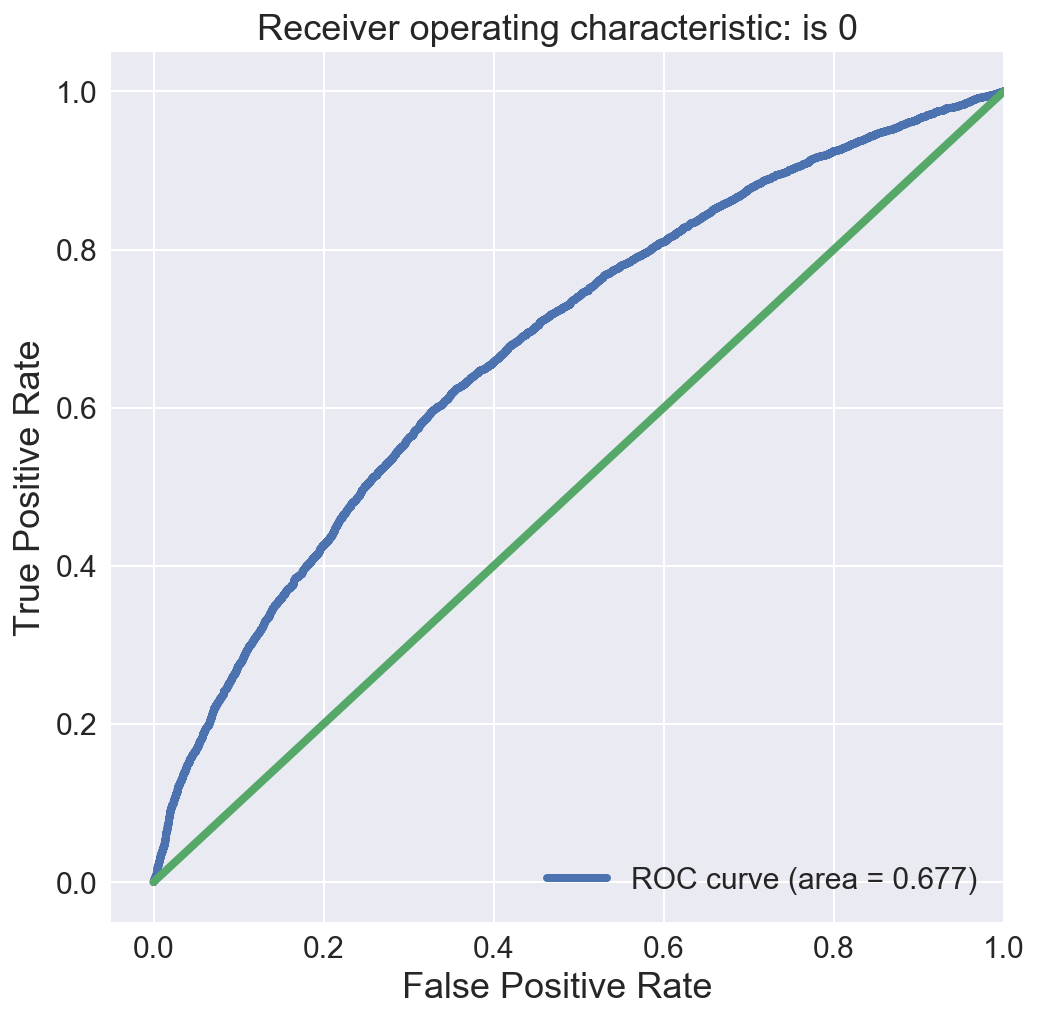

In [130]:
plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is 0', fontsize=18)
plt.legend(loc="lower right")
plt.show()

> - ROC curve compares the relationship between our TPR and FPR. We want to choose the point along our curve that maximizes TPs while minimizing FPs

> - ROC (0.677) means the area under the curve is 0.677. (1 is equivalent to perfect prediction)

<a id='lorpc2'></a>
### 3.1 KNN

KNN can be used for both classification and regression predictive problems. However, it is more widely used in classification problems in the industry. The only difference with regression problems from the classification will be using averages of nearest neighbors rather than voting from nearest neighbors.

In classification problems, KNN determines the class of each testing sample by taking the majority vote from its k nearest training samples. To arrive at the right number of nearest neighbors to consider, we performed a search over a list of multiple k values and then picked a k value that gave the best AUC score. The strength of this model is that it is robust to fluctuations in feature values, taking an aggregate similarity measurement across features (L2-Norm). A weakness of this model is that we are making an assumption about which distance metric to use. 

> - I started to evaluate KNN model with 5 neighbours

In [62]:
from sklearn.neighbors import KNeighborsClassifier

# Create an Instance of the model
kmodel = KNeighborsClassifier(n_neighbors=5)
#Fit the model with the training data
kmodel.fit(X_train,y_train)
#Predictions
predicted = kmodel.predict(X_test)

In [63]:
print "Baseline accuracy:\t\t\t\t\t", round (baseline_acc,3)
print "KNN (default parameters) test accuracy PCA:\t\t\t", round (accuracy_score(y_test, predicted),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:					0.524
KNN (default parameters) test accuracy PCA:			0.599
------------------------------------------------------------------------------------------


In [66]:
# The choice of the best parameter K is very crucial in the KNN algorithm.
number = np.arange(10, 600, 20)
accuracy = []
for k in number:
    kmodelb = KNeighborsClassifier(n_neighbors = k, n_jobs=1)
    kmodelb.fit(X_train,y_train)
    score = kmodelb.score(X_test, y_test)
    accuracy.append(score)    
# best accuracy
k_max = number[accuracy.index(max(accuracy))]
print 'Best accuracy with k =', k_max

 Best accuracy with k = 510


In [72]:
# Create an Instance of the model
kmodel2 = KNeighborsClassifier(n_neighbors=510)
#Fit the model with the training data
kmodel2.fit(X_train,y_train)
#Predictions
predicted2 = kmodel2.predict(X_test)

In [73]:
print "Baseline accuracy:\t\t\t\t\t\t", round (baseline_acc,3)
print "KNN (default parameters) test accuracy PCA:\t\t\t", round (accuracy_score(y_test, predicted),3)
print "KNN (optimal parameters) test accuracy PCA:\t\t\t", round (accuracy_score(y_test, predicted2),3)
print '------------------------------------------------------------------------------------------'


Baseline accuracy:						0.524
KNN (default parameters) test accuracy PCA:			0.599
KNN (optimal parameters) test accuracy PCA:			0.64
------------------------------------------------------------------------------------------


In [74]:
predicted_prob_k = kmodel2.predict_proba(X_test)

# Plot the ROC curve
fpr_k, tpr_k, thresholds_k = metrics.roc_curve(y_test, predicted_prob_k[:,1])
auc_k = metrics.auc(fpr_k,tpr_k)

In [75]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted_prob[:,1])
roc_auc = auc(fpr, tpr)

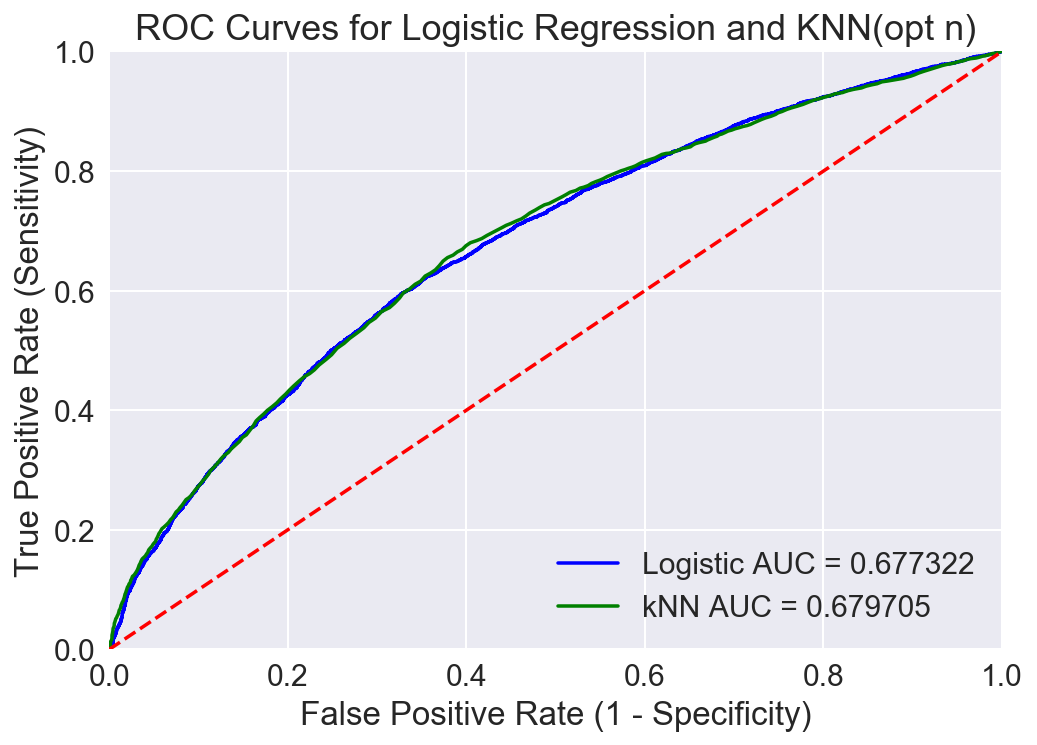

In [76]:
plt.plot(fpr, tpr, 'b', label='Logistic AUC = %f' % roc_auc)
plt.plot(fpr_k, tpr_k, 'g', label='kNN AUC = %f' % auc_k)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for Logistic Regression and KNN(opt n)')
plt.legend(loc='lower right')
plt.show()


> - The area ROC curve (or AUC) performance metric for classification are similar for both models, similar ability to discriminate between positive and negative classes. (An area of 1.0 represents a model that made all prediction perfectly).

<a id='lorpc3'></a>
### 3.2 Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. Also, since it uses decision trees it can learn non-linear hypothesis and is in top two classifiers in terms of performance.

In [77]:
from sklearn.ensemble import RandomForestClassifier

# Create an Instance of the model
rfc1 = RandomForestClassifier(random_state=37)
#Fit the model with the training data
rfc1.fit(X_train, y_train)
#Predictions
yhat_rfc1 = rfc1.predict(X_test)

In [78]:
# Evaluate the model with test data
print "Baseline accuracy PCA:\t\t\t\t\t", round (baseline_acc,3)
print "Random Forest (default parameters) test accuracy PCA:\t", round (accuracy_score(y_test, yhat_rfc1),3)
print '------------------------------------------------------------------------------------------'

Baseline accuracy PCA:					0.524
Random Forest (default parameters) test accuracy PCA:	0.591
------------------------------------------------------------------------------------------


#### Gridsearch Logistic Regression (RF)

In [ ]:
#Due to the impossibility of computer resources of running with more paremeter. 
#Here are the analysis based on number estimators = 700 

In [79]:
rfc_params = {
    'n_estimators':[700],
#    'max_features':[0.9,1.0], # ideal, square root the number of features
}

In [80]:
rfc2 = GridSearchCV(rfc1, param_grid=rfc_params, cv=5)
rfc2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=37,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [700]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [81]:
rfc2.best_params_

{'n_estimators': 700}

In [82]:
rfc3 = rfc2.best_estimator_.fit(X_train, y_train)

In [86]:
yhat_rfc3 = rfc3.predict(X_test)

print "Baseline accuracy:\t\t\t\t\t\t", round (baseline_acc,3)
print "Logistic regression (default parameters) test accuracy PCA\t", round (accuracy_score(y_test, yhat_lr1),3)
print "Random Forest (default parameters) test accuracy PCA:\t\t", round (accuracy_score(y_test, yhat_rfc1),3)
print "Random Forest (optimal parameters) test accuracy PCA:\t\t", round (accuracy_score(y_test, yhat_rfc3),3)

Baseline accuracy:						0.524
Logistic regression (default parameters) test accuracy PCA	0.631
Random Forest (default parameters) test accuracy PCA:		0.591
Random Forest (optimal parameters) test accuracy PCA:		0.642


> - Random Forest gets a decent accuracy value 0.642.

> - For Random Forest, there are two main parameters to be considered: number of trees and number of features at each decision point.


- Consideration to be taken into account:
    
> * If a model has many parameters (generally low bias), it will fit the data well but yield high variance. Conversely, if the model has few parameters (generally high bias), it may not fit the data particularly well,but this fit will not change much as for different data sets (low variance)".

> * Why? If our model complexity exceeds the level of complexity , we are in effect over-fitting our model; while if our complexity falls short, we are under-fitting the model. 



I created a decision tree model with the optimal parameters.

<a id='lorpc4'></a>
### 3.4 DecisionTreeClassifier

Decision Trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. One important disadvantage is Decision-tree learners can create overfitting.
DecisionTreeClassifier is a class capable of performing multi-class classification on a dataset.

In [136]:
from sklearn.tree import DecisionTreeClassifier
model_tree_2 = DecisionTreeClassifier()

param_grid = {
    'max_depth': range(4,20),
}

model_tree_2_gs = GridSearchCV(model_tree_2,param_grid=param_grid,cv=5)
model_tree_2_gs.fit(X_train,y_train)
print 'The best parameters for a decision tree classifier: %s' % str(model_tree_2_gs.best_params_)
print 'These parameters give a score of: %f' % model_tree_2_gs.best_score_
predicted_prob_d = model_tree_2_gs.predict_proba(X_test)
print '-------------------------------------------------------------------------------------------------------------'

The best parameters for a decision tree classifier: {'max_depth': 6}
These parameters give a score of: 0.616580


<a id='lorpc5'></a>
### 3.5 Optim DecisionTreeClassifier

In [137]:
dtc_opt = DecisionTreeClassifier(max_depth=6)
dtc_opt.fit(X_train, y_train)
yhat_dt = dtc_opt.predict(X_test)

# Evaluate the model with test data
print "Baseline accuracy:", baseline_acc
print "Decision tree test accuracy:\t", accuracy_score(y_test,yhat_dt)
print '-------------------------------------------------------------------------------------------------------------'


Baseline accuracy: 0.523674583956
Decision tree test accuracy:	0.612490241998


<a id='lorpc6'></a>
### 3.6 BaggingClassifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. 

I used sklearn's BaggingClassifier with the base estimator which optimized a decision tree model. 

In [138]:
from sklearn.ensemble import BaggingClassifier

# Create an Instance of the model
bag = BaggingClassifier(dtc_opt)
#Fit the model with the training data
bag.fit(X_train, y_train)
#Predictions
yhat_bag = bag.predict(X_test)
# Evaluate the model with test data
print "Baseline accuracy:", baseline_acc
print "Decision tree (with bagging) test accuracy:\t", accuracy_score(y_test,yhat_bag)
print 'Decision tree (with bagging) accuracy: %f' % cross_val_score(bag,X_test,
                                                y_test,cv=5).mean()
print '-------------------------------------------------------------------------------------------------------------'

Baseline accuracy: 0.523674583956
Decision tree (with bagging) test accuracy:	0.630601092896
Decision tree (with bagging) accuracy: 0.626621


<a id='lorpc7'></a>
### 3.6 SVM (RBF)


- The Support Vector Machine (SVM) algorithm is a different approach to classification.

- SVM still fits a decision boundary like a logistic regression, but uses a different loss function called the "hinge loss" (as opposed to the log loss in logistic regression).

- SVM classifier was trained with linear, polynomial, and radial kernels. We choose RBF because it yielded the best accuracy. An advantage of SVM is that it is guaranteed to converge to a global minimum. However, the computation time required is comparatively higher and it does not return probabilistic confidence

In [139]:
from sklearn import svm
# Create an Instance of the model and fit the model with the training data
rbf_svc = svm.SVC(kernel='rbf').fit(X_train,y_train)  # default kernel
#Predictions
yhat_svm_rbf = rbf_svc.predict(X_test)

# Evaluate the model with test data
print "Baseline accuracy:", baseline_acc
print "SVM (rbf) test accuracy:\t", accuracy_score(y_test,yhat_svm_rbf)
# Print accuracy model with five-fold cross validation
print cross_val_score(rbf_svc,X_test,y_test , cv=5, scoring='accuracy').mean()
print '-------------------------------------------------------------------------------------------------------------'

Baseline accuracy: 0.523674583956
SVM (rbf) test accuracy:	0.644028103044
0.637081671673


<a id='lorpc8'></a>
### 3.7 SVM (Linear)

- I used linear kernel.

In [ ]:
svc = svm.SVC(kernel='linear').fit(X_train,y_train)

#Predictions
yhat_svm_linear = svc.predict(X_test)
# Evaluate the model with test data
print "Baseline accuracy:", baseline_acc
print "SMV (linear) test accuracy:\t", accuracy_score(y_test,yhat_svm_linear)
# Print accuracy model with five-fold cross validation
print cross_val_score(svc,X_test,y_test , cv=5, scoring='accuracy').mean()
print '-------------------------------------------------------------------------------------------------------------'

Baseline accuracy: 0.523674583956
SMV (linear) test accuracy:	0.620296643247
0.621936581032


<a id='lorpc9'></a>
### 3.7 SVM (Poly)

- I used SVM with polynomial kernel.

In [25]:
poly_svc = svm.SVC(kernel='poly', degree=5).fit(X_train,y_train)

#Predictions
yhat_svm_poly = poly_svc.predict(X_test)
# Evaluate the model with test data
print "Baseline accuracy:", baseline_acc
print "SMV (poly) test accuracy:\t", accuracy_score(y_test,yhat_svm_poly)
# Print accuracy model with five-fold cross validation
print cross_val_score(poly_svc,X_test,y_test , cv=5, scoring='accuracy').mean()
print '-------------------------------------------------------------------------------------------------------------'

Baseline accuracy: 0.523674583956
SMV (poly) test accuracy:	0.611397345824
0.598907024748


> - # Summary: Appling PCA components - Accuracy
> - ------------------------


> - For classification, I have examined different classifiers starting with KNN,Random Forest, Decision Tree, Bagging Classifier,SVMs with the linear and poly basis function kernels. Each model was optimised using techniques such as Gridsearch for parameter tuning to ensure optimal results.

> - Initially, I have used classification Accuracy as evaluation metric. Accuracy is the number of correct predictions made as a ratio of all predictions made. This metric is suitable when there are an equal number of observations in each class and that all predictions and prediction errors are equally important. In our analysis, the dataset is balanced.
 

> - Plot below compares each model on the test set:

#### Features: PCA components 

Baseline Accuracy =  0.524 

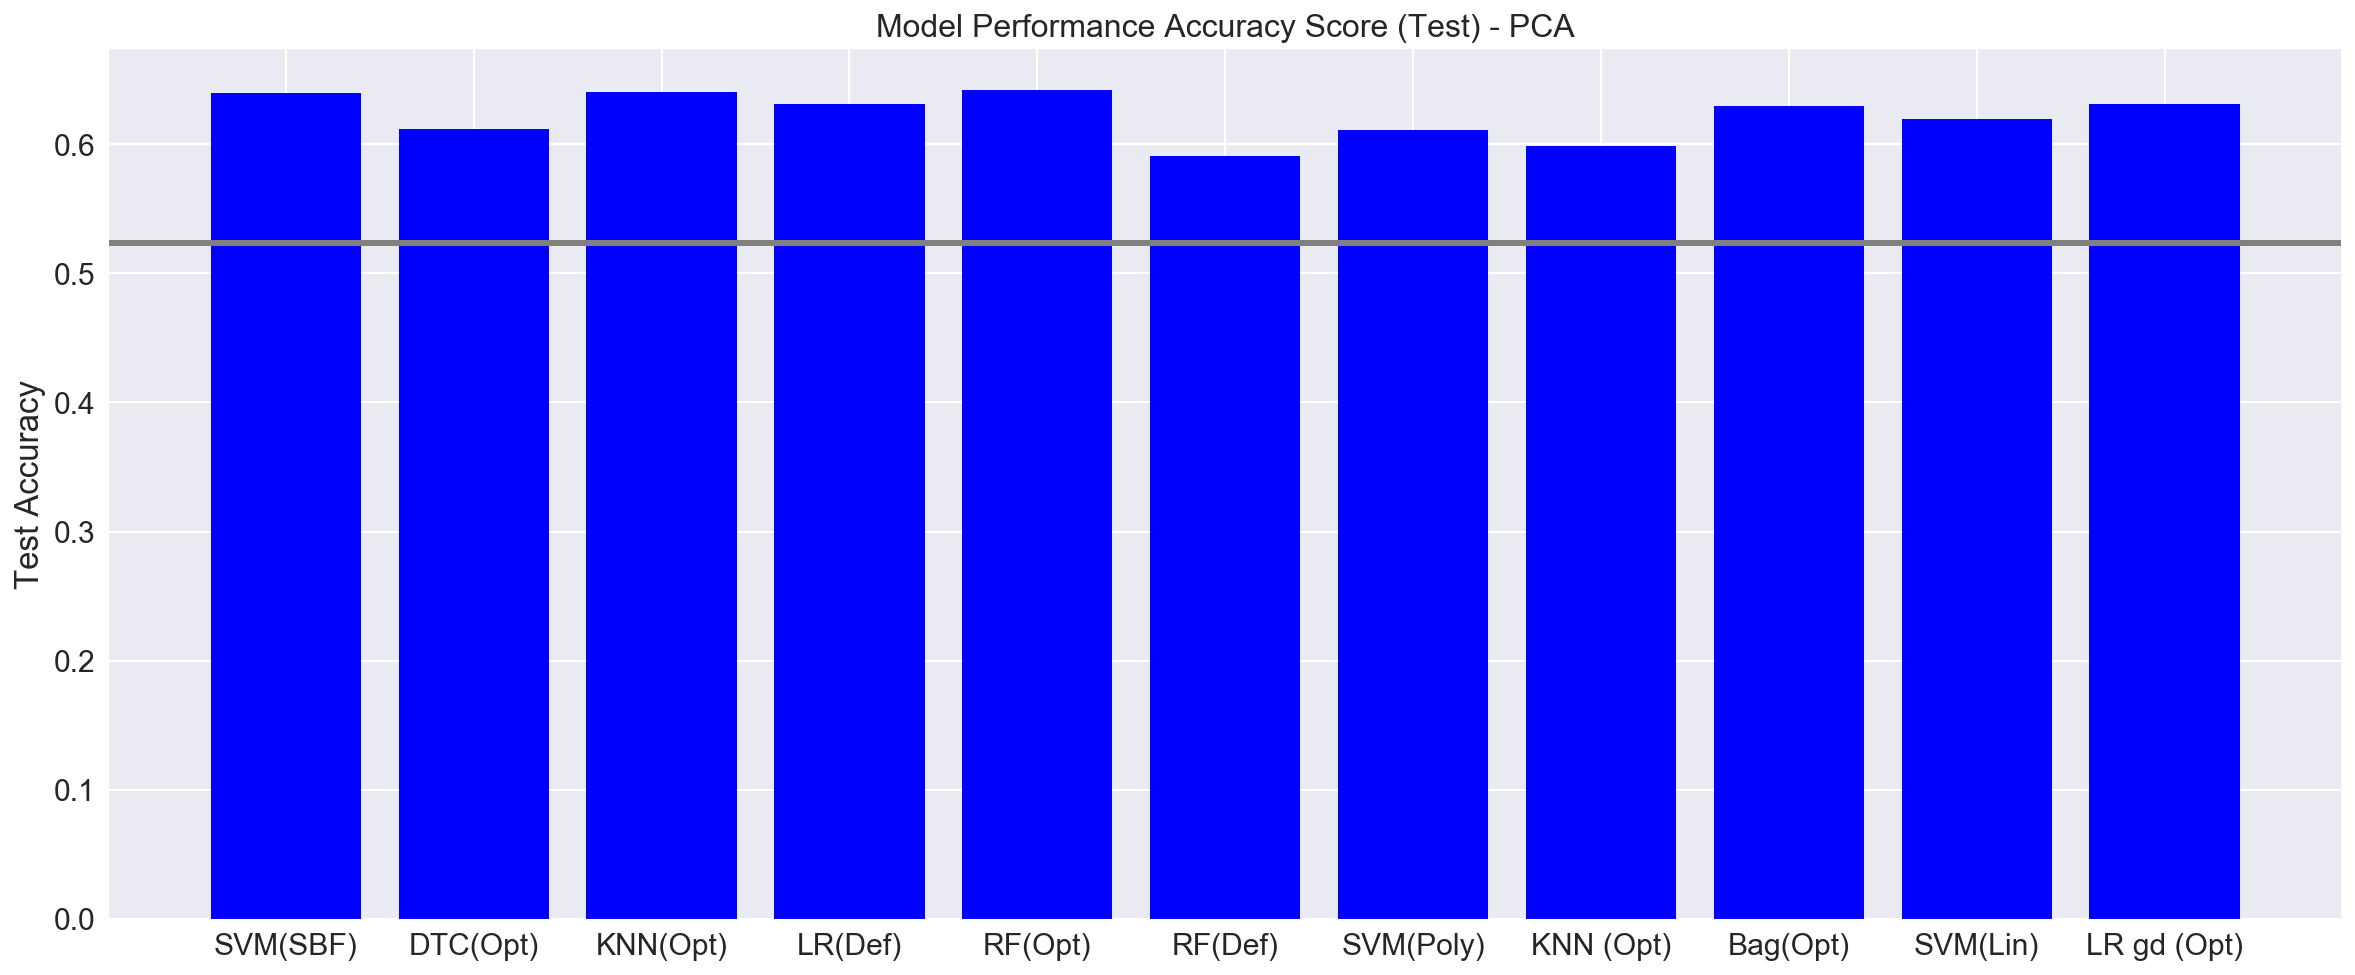

In [113]:
plt.figure(figsize = (20,8))

D = {'RF(Opt)':0.642,'KNN(Opt)':0.641,'SVM(SBF)':0.64,    
    'LR(Def)':0.631, 'LR gd (Opt)':0.631,'Bag(Opt)':0.630,
    'SVM(Lin)':0.62,'DTC(Opt)':0.612,'SVM(Poly)':0.611,    
    'KNN (Opt)':0.599, 'RF(Def)':0.591}

color = sns.diverging_palette(h_neg=10, h_pos=250, s=90, l=30, as_cmap=True, center="light",)
plt.bar(range(len(D)), D.values(),align='center', color = "b")
plt.xticks(range(len(D)), D.keys())
plt.axhline(0.524, label = 'Baseline Performance',lw=3, c='grey', alpha=1.0)
plt.ylabel('Test Accuracy')
plt.title('Model Performance Accuracy Score (Test) - PCA', fontsize = 16)
print 'Baseline Accuracy =  0.524 ', 

plt.show()

 > - Random Forest and KNN (Optimal parameters) models achieved the best accuracy -64% - after applying pricipal component analysis to reduce number of feature. Very similar shows SVM (SBF)

## Analysis best model

I used different machine learning evaluation metrics to evaluate Random Forest and KNN (Optimal parameters)

#### Confusion Matrix

The confusion matrix is a handy presentation of the accuracy of a model with two or more classes. 
The table presents predictions on the x-axis and accuracy outcomes on the y-axis. The cells of the table are the number of predictions made by a machine learning algorithm. This allows more detailed analysis than mere proportion of correct classifications (accuracy).

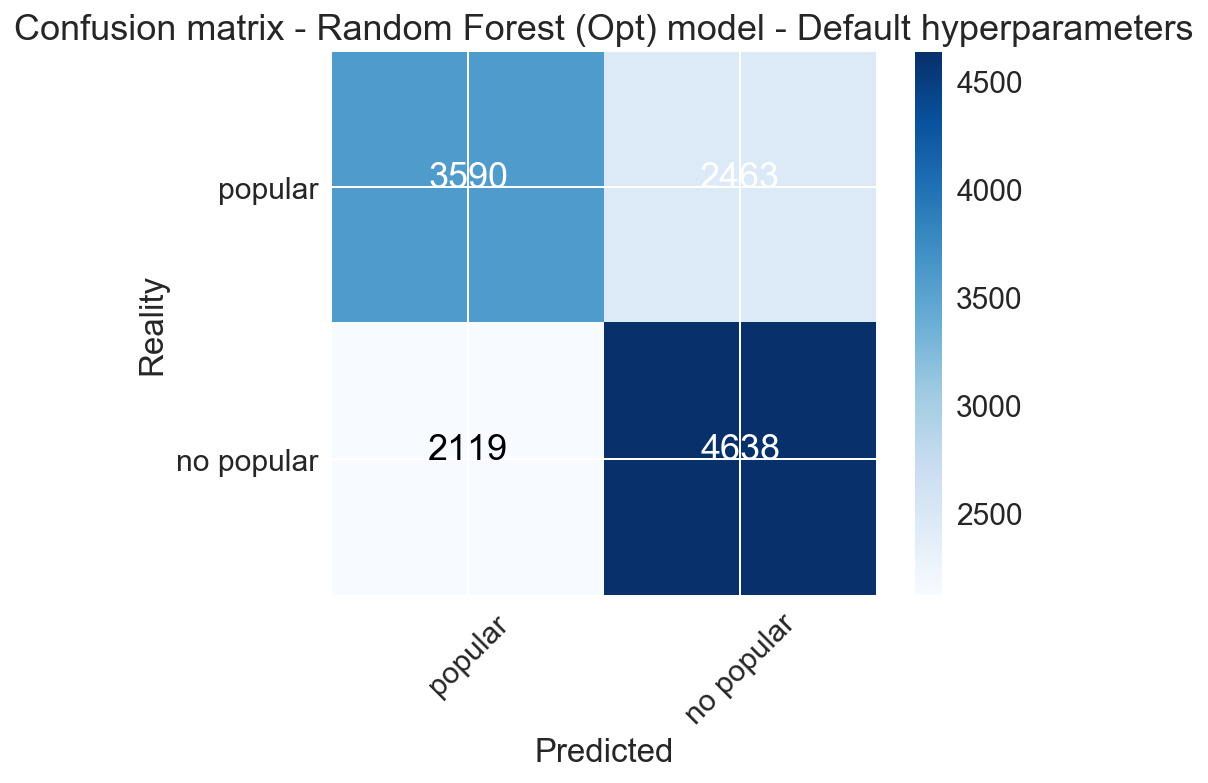

In [114]:
# RANDOM RANDOM FOREST (OPT)
# Computing the confusion matrix for RF (Opt Parameters)
confmat_rfc3 = confusion_matrix(y_test, yhat_rfc3)

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmat_rfc3, ['popular','no popular'],\
                      'Confusion matrix - Random Forest (Opt) model - Default hyperparameters',\
                      xlab='Predicted', ylab='Reality')
plt.show()

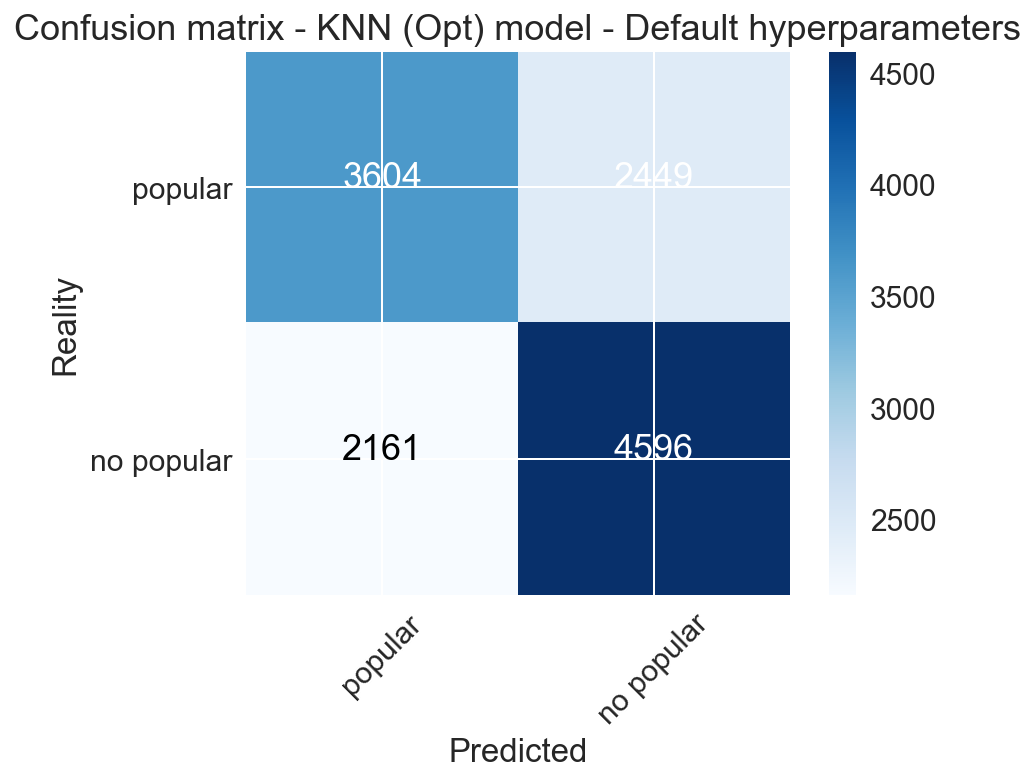

In [115]:

# Computing the confusion matrix for KNN (Opt)
confmat_knn2 = confusion_matrix(y_test, predicted2)

# Plotting it using the function:
sns.set(font_scale=1.5)
plt.figure(figsize=(7,5))
plot_confusion_matrix(confmat_knn2, ['popular','no popular'],\
                      'Confusion matrix - KNN (Opt) model - Default hyperparameters',\
                      xlab='Predicted', ylab='Reality')
plt.show()

The two final tables of confusion contain the average values for all classes combined.

#### > - We can observe that the confusion matrix is very similar but KNN (Opt) performs slightly better in the outcome True positives (3604 Vs 3590). Both models have significantly improved regarding best logistic model (3443 class  popular as correctly predicted) 

Built a text report showing the main classification metrics for both models

In [117]:
print "RF(600)classification report:\n",classification_report(y_test,yhat_rfc3)
print "SVM(rbf)classification report:\n",classification_report(y_test,predicted2)


RF(600)classification report:
             precision    recall  f1-score   support

          0       0.63      0.59      0.61      6053
          1       0.65      0.69      0.67      6757

avg / total       0.64      0.64      0.64     12810

SVM(rbf)classification report:
             precision    recall  f1-score   support

          0       0.63      0.60      0.61      6053
          1       0.65      0.68      0.67      6757

avg / total       0.64      0.64      0.64     12810



> - We can see that the classification report is very similar too.

The f1-score gives us the harmonic mean of precision and recall.The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.
The support is the number of samples of the true response that lie in that class.

In [118]:
# Predicted probabilities for  Random Forest (Opt)
predicted_prob_rfc3 = rfc3.predict_proba(X_test)

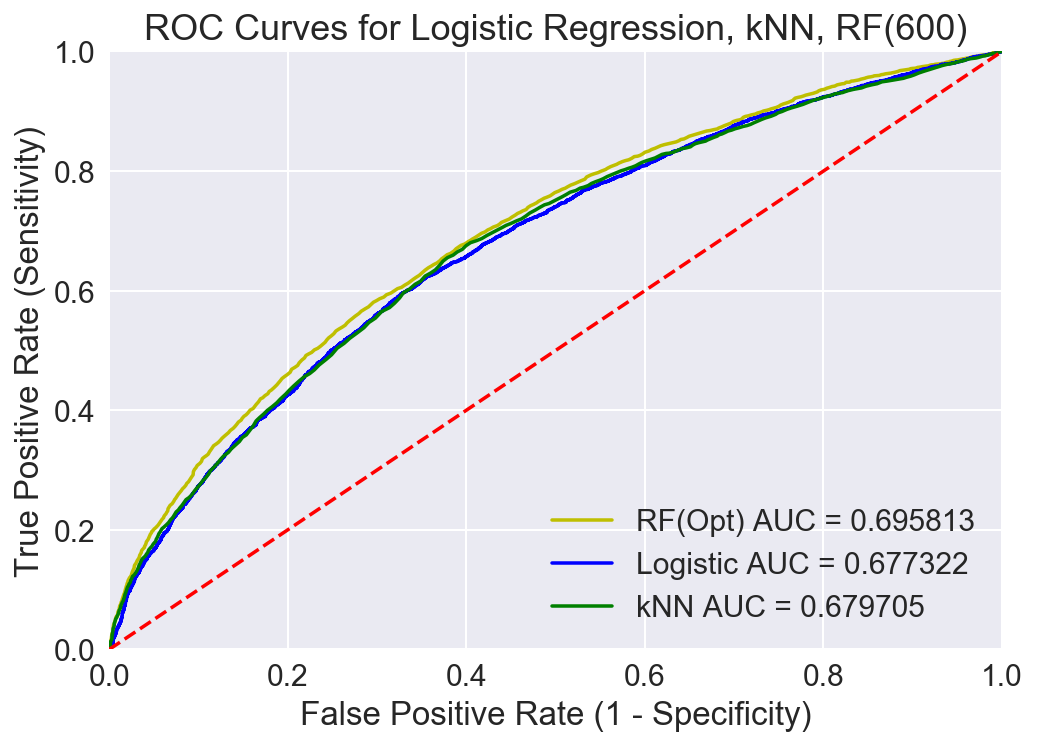

In [120]:

fpr_d, tpr_d, thresholds_d = metrics.roc_curve(y_test, predicted_prob_rfc3[:,1])
auc_d = metrics.auc(fpr_d,tpr_d)


plt.plot(fpr_d, tpr_d, 'y', label='RF(Opt) AUC = %f' % auc_d)

plt.plot(fpr, tpr, 'b', label='Logistic AUC = %f' % roc_auc)
plt.plot(fpr_k, tpr_k, 'g', label='kNN AUC = %f' % auc_k)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves for Logistic Regression, kNN, RF(600)')
plt.legend(loc='lower right')
plt.show()


> - ROC curve compares the relationship between our TPR and FPR. 

> - ROC RF(opt) the area under the curve is 0.695, the best ROC Value. This mean Random Forres with n=700 gives good result.

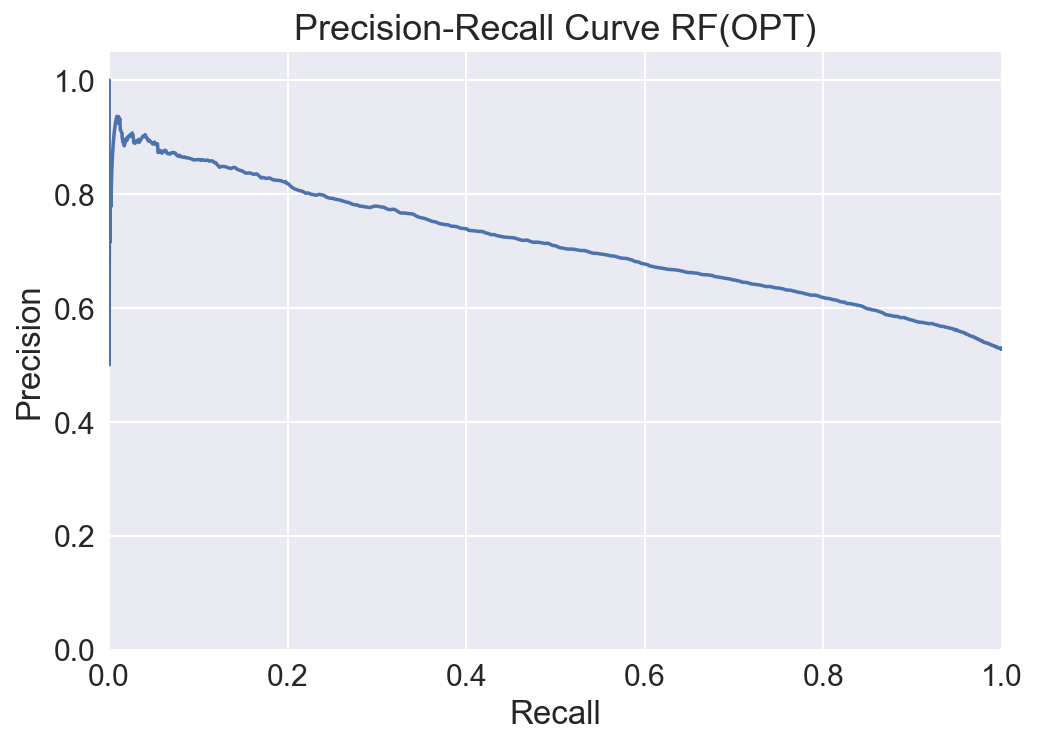

In [122]:
# Plot the Precision - Recall Curve for RF(Opt)

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = metrics.precision_recall_curve(y_test,                                                       predicted_prob_rfc3[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('Precision-Recall Curve RF(OPT)')
plt.show()



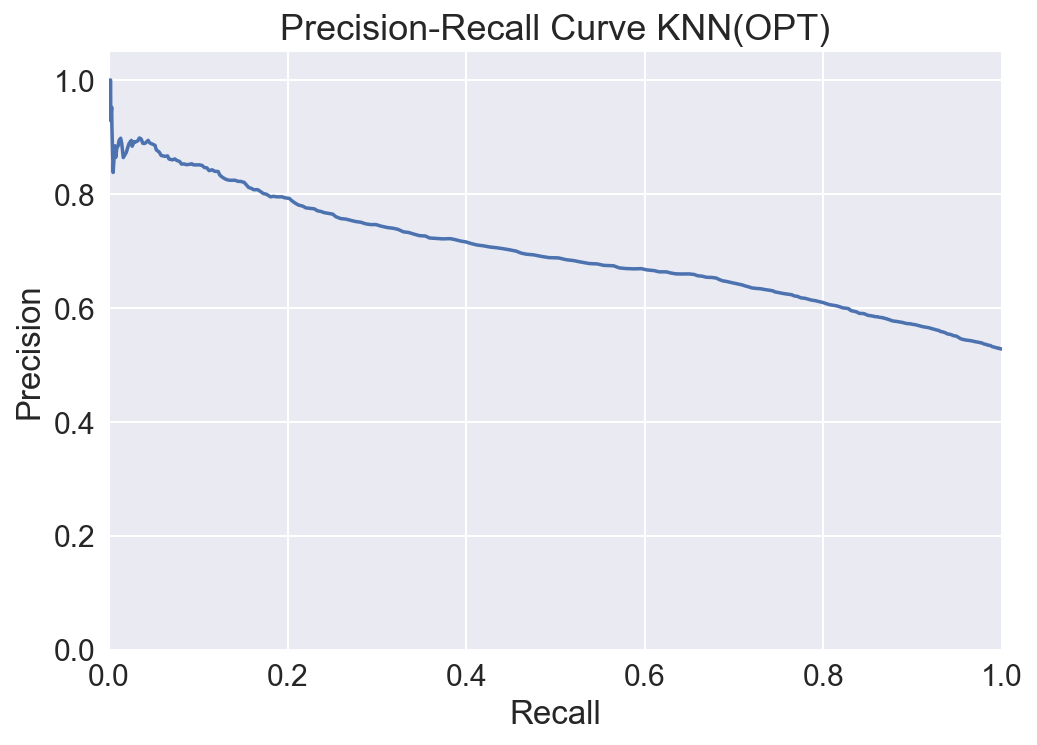

In [131]:
# Plot the Precision - Recall Curver for KNN(Opt)

from sklearn.metrics import precision_recall_curve

# Plot the ROC curve
fpr_k, tpr_k, thresholds_k = metrics.roc_curve(y_test, predicted_prob_k[:,1])
auc_k = metrics.auc(fpr_k,tpr_k)

precision, recall, thresholds = metrics.precision_recall_curve(y_test,
                                                      predicted_prob_k[:,1])
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0,1.05])
plt.xlim([0.0,1.0])
plt.title('Precision-Recall Curve KNN(OPT)')
plt.show()


> - Precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned 



In [132]:
# feature importance  from the RF(Opt):

rfc3.feature_importances_

array([ 0.05115175,  0.04245034,  0.05815275,  0.04372936,  0.04280429,
        0.04797268,  0.0404829 ,  0.043407  ,  0.04388523,  0.04397517,
        0.04354703,  0.05218116,  0.04456613,  0.04026495,  0.03923392,
        0.03741233,  0.03780805,  0.03713212,  0.03788137,  0.03785105,
        0.03860862,  0.0487434 ,  0.0467584 ])


> - Interpretation  TOP3

>         - PC2 (0.058) kw_avg_avg
>         - PC11(0.052) data_channel_is_entertainment
>         - PC0 (0.051) data_channel_is_world


<a id='lorpc11'></a>


# Conclusion Machine Learning 

From this analysis, it is clear that any algorithm can reach 65% accuracy given the data set. To improve accuracy, we could double check the model selection and features. However, it seems that features extracted from the text are important. The original data set does not provide this information.

The models provided here demonstrate that utilising a two-class label system with a partition at the median provides what may be the best classifier, compared to using the original "continuous" number of shares.

Applying PCA, we found that Random Forest classifier, KNN and SVM can be considered as best models across different variations of the data set when the target is binarised at the median. The difference between the accuracy value in training and testing sets is very low, indicating this model can be used to predict future unknown cases.

Using feature selection techniques, like RFECV or Lasso, do not seem to improve information compared to using all the features.

From the 53 selected features, the top variables make the most sense in trying to estimate the number of shares: 

- kw_avg_avg 
- kw_max_max (the lower is the maximun influence)followed by 
- data_channel_is_entertainment, 
- is_weekend and LDA OO or LDA02. 

It seems that the editorial content of an article its more predictive than the rest of features.



### Insights

> - consideration the number of key words
> - increase the number of articles of entertainment
> - referenced articles in Mashable

### Next thing I want to try:

> - Create ROC curves for all models I tried and Precision-Recall plot in a single plot.

> - Features: All variables, I would like to run more models.

> - Features: PCA, I would like to create a test_model function.